# DNS to CE2 Kinetic Energy

The initial KE from our CE2 run does not line up with the final KE of the DNS. 

Load data...

In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import numpy as np
import h5py

In [3]:
plt.style.use('prl')

In [4]:
filebase = 'scratch/busse_annulus_ra8.00e+07_beta5.00e+05_C0.00e+00_Pr1.00e+00_filter5.00e-01_nx512_ny256_CFL_xy/'

ts_filen = filebase + 'timeseries/timeseries_s1.h5'
sn_filen = filebase + 'snapshots.h5'

In [17]:
ts_ce2_filen = 'CE2/run_C_DNS_burst/data_scalars.h5'

In [18]:
ts = h5py.File(ts_filen,'r')
sn = h5py.File(sn_filen,'r')
ts_ce2 = h5py.File(ts_ce2_filen, 'r')

In [19]:
ts_time = ts['scales/sim_time'][:]
ts_ekin = ts['tasks/Ekin'][:,0]
ts_ezonal = ts['tasks/E_zonal'][:,0]
ts_enz = ts_ekin-ts_ezonal

In [20]:
an_mask = (ts_time > 1.5)

In [25]:
max_idx = np.argmax(ts_enz[an_mask])
min_idx = np.argmin(ts_ekin[an_mask])

tmin = ts_time[an_mask][min_idx]
tmax = ts_time[an_mask][max_idx]

1.8220006765925754

In [26]:
t_quiet = 1.69
t_minshear = 1.702
t_maxshear = 1.672
idx_burst = int(1000*tmax)
idx_quiet = int(1000*t_quiet)
idx_minshear = int(1000*t_minshear)
idx_maxshear = int(1000*t_maxshear)

The start KE of CE2 is ~10.25 times higher than the DNS time point it is branched from:

In [64]:
ts_ce2['tasks/KE'][0,0,0,0]/ts_ekin[idx_burst][0]

10.252181293412866

First, let's check that the KE is correctly computed in the CE2 code.

By definition,
$$E_k = \frac{1}{2} \int u^2 + v^2 dx dy$$.

To get this in streamfunction-vorticity form, with streamfunction $\psi$ such that

$$\mathbf{u} = \partial_y \psi \hat{\mathbf{x}} - \partial_x \psi \hat{\mathbf{y}}$$

and vorticity $\zeta = \hat{\mathbf{z}} \cdot (\nabla \times \mathbf{u})$
 
$$\zeta = -\nabla^2 \psi,$$
we can write
$$ \begin{align}
    E_k &= \frac{1}{2} \int (\partial_y \psi)(\partial_y \psi) + (\partial_x \psi)(\partial_x \psi) dx dy\\
    &=\frac{1}{2} \int -\psi \partial_y^2 \psi - \psi \partial_x^2 \psi dx dy\\
    &= \frac{1}{2} \int \psi \zeta dx dy.
    \end{align}
$$
The second line arises from integration by parts. With periodic boundaries in $x$ and $\psi \propto \sin(y)$, the boundary terms go to zero.

Next, we need to split this into fluctuating and zonal means,

$$
\begin{align}
E_k &= \frac{1}{2} \int (\bar{\psi} + \psi')(\bar{\zeta} + \zeta') dx dy\\
&= \frac{1}{2} \int (\bar{\psi}\bar{\zeta} + \psi'(x,y)\zeta'(x,y) dx dy
\end{align}
$$
where cross terms drop because of Reynolds rules. Recalling that $c_\psi \equiv \bar{\psi}$, the first term in the kinetic energy is the zonal mean kinetic energy,
$$
E_{k,zonal} = \frac{1}{2} \int c_\psi c_\zeta dx dy
$$

Noting that the second cumulant under zonal averages is

$$
c_{\psi\zeta}(\xi, y_1, y_2) = \frac{1}{L_x} \int \psi'(x_1, y_1) \zeta'(x_1 -\xi, y_2) dx_1,
$$

we can write the non-zonal (fluctuation) kinetic energy in terms of $c_{\psi\zeta}$ as follows

$$
\begin{align}
E_{k,nz} &= \frac{1}{2} \int \psi'(x,y)\zeta'(x,y) dx dy\\
    &= \frac{1}{2} \int L_x  c_{\psi\zeta}(0,y,y) dy
\end{align}
$$

However, in the CE2 simulation code as of 23 Mar 2021, there is an extra factor of $L_x$ in the KE definition.

So, we must scale this output by $L_x$.

In [82]:
Lx = 2*np.pi
ts_ce2_ekin = ts_ce2['tasks/KE'][:-10,0,0,0]/Lx
ts_ce2_ezonal = ts_ce2['tasks/KE_mean'][:-10,0,0,0]/Lx
ts_ce2_nz = ts_ce2_ekin - ts_ce2_ezonal
ts_ce2_sim_time = ts_ce2['scales/sim_time'][:-10]

However, even after doing this, there is a mismatch at the start of CE2:

In [95]:
(ts_ce2_ekin[0])/ts_ekin[idx_burst,0]

1.6316853303209184

The problem is that the DNS to CE2 code does not include the factor of $1/L_x$ in the definition of the second cumulant. If we instead use the separately calculated zonal and non-zonal energies, and then adjust the latter to include the $1/L_x$, we get what we want.

In [92]:
(ts_ce2_ezonal[0]+ts_ce2_nz[0]/Lx)/ts_ekin[idx_burst,0]

0.9999569514542083

Same thing in plots. The top panel contains only the $L_x$ correction to the CE2 output. The bottom panel also corrects the the non-zonal kinetic energy.

**NB:** Because this arises from the initial conditions, the simulatiuon needs to be rerun: the first correction is the only one necessary for the CE2 output. The other correction comes in the calculation of the initial conditions. 

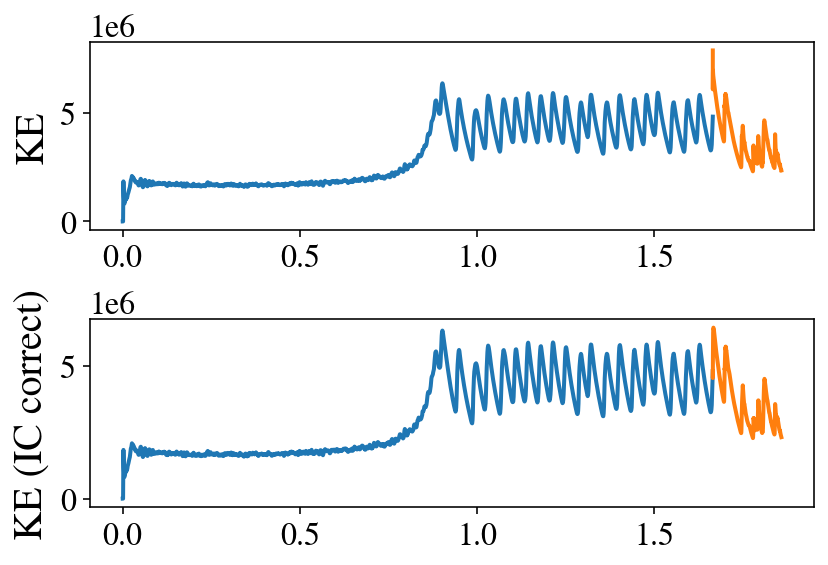

In [99]:
plt.subplot(211)
plt.plot(ts_time[:idx_burst+1], ts_ekin[:idx_burst+1], label='total')
plt.plot(ts_ce2_sim_time+ts_time[idx_burst], ts_ce2_ekin)
plt.ylabel("KE")
plt.subplot(212)
plt.plot(ts_time[:idx_burst+1], ts_ekin[:idx_burst+1], label='total')
plt.plot(ts_ce2_sim_time+ts_time[idx_burst], ts_ce2_ezonal + ts_ce2_nz/Lx)
plt.ylabel("KE (IC correct)")
plt.tight_layout()
#plt.xlim(1.6,1.75)
#plt.ylim(3e3,1e7)
#plt.yticks([1e4,1e5,1e6])

Text(0, 0.5, 'Kinetic energies')

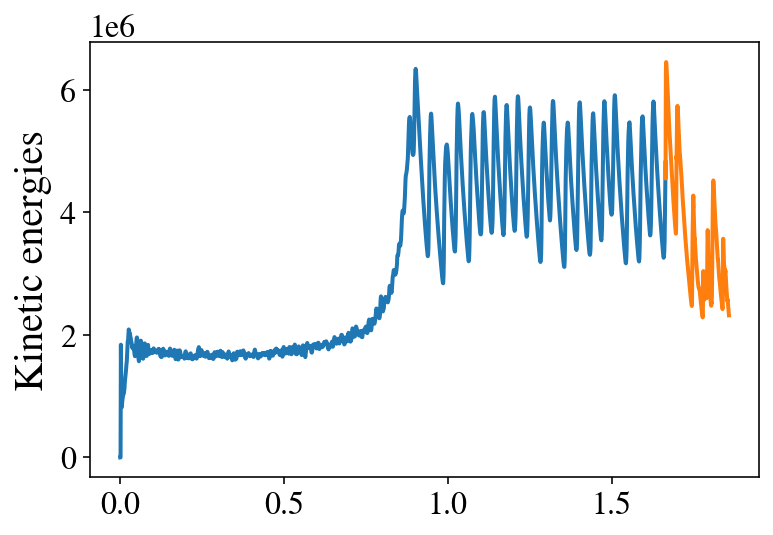

In [91]:

#plt.xlim(1.6,1.75)
#plt.ylim(3e3,1e7)
#plt.yticks([1e4,1e5,1e6])

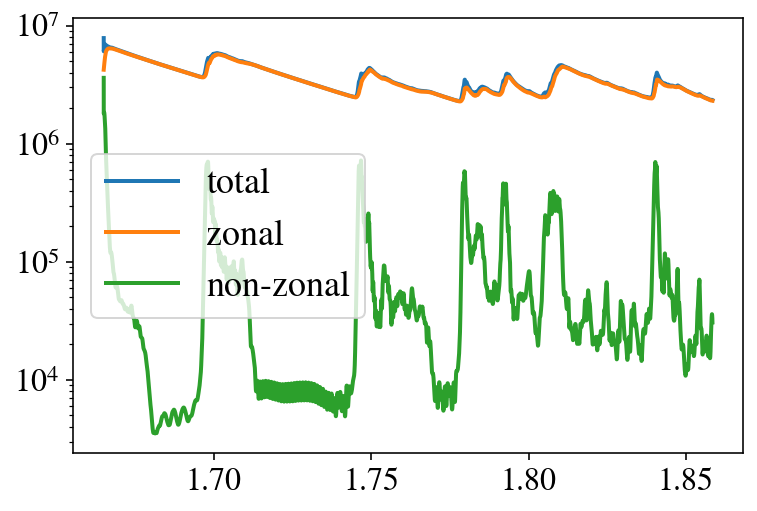

In [86]:
plt.semilogy(ts_time[idx_burst]+ts_ce2_sim_time,ts_ce2_ekin, label='total')
plt.semilogy(ts_time[idx_burst]+ts_ce2_sim_time,ts_ce2_ezonal, label='zonal')
plt.semilogy(ts_time[idx_burst]+ts_ce2_sim_time,ts_ce2_nz, label='non-zonal')
plt.legend()